In [1]:
#from imports import *
import torch
import matplotlib.patches as patches
import torchvision
from datasets.bdd import *
import pickle
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os, matplotlib
COLOR = "yellow"
matplotlib.rcParams["text.color"] = COLOR
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
labels = {
        "bus": 1,
        "traffic light": 2,
        "traffic sign": 3,
        "person": 4,
        "bike": 5,
        "truck": 6,
        "motor": 7,
        "car": 8,
        "train": 9,
        "rider": 10,
        "drivable area": 11,
        "lane": 12,
        }

In [3]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    #model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, min_size=256, max_size=512, image_mean=[0.5,0.5,0.5], image_std=[0.5,0.5,0.5])
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features,num_classes)
    return model.cpu()

In [5]:
model = get_model(len(labels))

In [6]:
#checkpoint = torch.load('saved_models/sideRight.pth')
checkpoint = torch.load('saved_models/bdd100k_5.pth')
model.load_state_dict(checkpoint['model'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']

<All keys matched successfully>

In [7]:
def plot_from_image_preds(img,total_preds, confidences):
    fig,ax = plt.subplots(1)
    for i in range(len(total_preds)):
        xy = total_preds[i]['boxes'][0],total_preds[i]['boxes'][1]
        width = total_preds[i]['boxes'][2]-total_preds[i]['boxes'][0]
        height = total_preds[i]['boxes'][3]-total_preds[i]['boxes'][1]
        rect = patches.Rectangle(xy,width,height,linewidth=1,edgecolor='r',facecolor='none')
        ax.text(xy[0],xy[1],(labels[total_preds[i]['labels'].item()]))
        ax.add_patch(rect)
    ax.imshow(img)
    

In [14]:
with open("datalists/bdd100k_val_images_path.txt", "rb") as fp:
    val_img_paths = pickle.load(fp)
#im0 = Image.open(val_img_paths[7491])
im0 = Image.open('./00666.jpg')
#im0 = Image.open('./9.jpg')
#im0 = Image.open('./9.jpg')
im0_tensor = torchvision.transforms.ToTensor()(im0);

In [15]:
im0_tensor.shape

torch.Size([3, 360, 640])

In [10]:
def get_preds(img):
    #def get_preds(idx,img_datalist):
    #im0 = Image.open(img_datalist[idx])
    im0 = img
    #im0_tensor = torchvision.transforms.ToTensor()(im0)
    #im0_tensor = torchvision.transforms.Resize((256,512))(im0_tensor)
    pred = model([im0_tensor.cuda()])
    total_preds = []
    for n,confidence in enumerate(pred[0]['scores']):
        if confidence>0.75:
            pred_update = {}
            pred_update['boxes'] = pred[0]['boxes'][n]
            pred_update['labels'] = pred[0]['labels'][n]
            pred_update['scores'] = pred[0]['scores'][n]
        total_preds.append(pred_update)
    return im0,total_preds, confidence

In [11]:
# Run it only once
model.eval()
model.cuda()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [12]:
labels = {k:v for v,k in labels.items()}

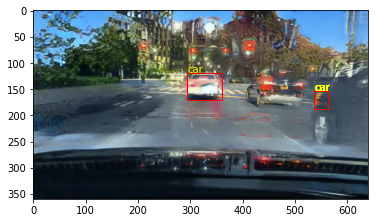

In [16]:
#im, total_preds = get_preds(15,val_img_paths)
im, total_preds, confidences = get_preds(im0)
plot_from_image_preds(im,total_preds,confidences)